In [1]:
#### import pandas as pd
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from helper import *
from amftrack.notebooks.P_experiment.helper import get_polygons
%load_ext autoreload
%autoreload 2
plt.style.use('presentation.mplstyle')
C_max2 = 1.53
def fit_function(x, C_max):
    return 1+C_max * 1/x**(3/2)
%matplotlib widget

# Read the Excel file
path = r'C:\Users\coren\Documents\PhD\Pexperiment'
path_excel = os.path.join(path,'summary.xlsx')
df = pd.read_excel(path_excel)
df['date_from_unique_id'] = pd.to_datetime(df['unique_id'].str.split('_').str[1], format='%Y%m%d')
    
# Convert 'day' column to datetime
df['day_sample'] = pd.to_datetime(df['day_sample'], format='%Y%m%d')  # Update the format as necessary
df['day_start'] = pd.to_datetime(df['start'], format='%Y%m%d')  # Update the format as necessary

df['time_elapsed'] = df['day_sample'] - df['day_start']
df['time_elapsed_day'] = df['time_elapsed'].dt.days
df['time_since_crossing'] = df['day_sample'] - df['date_from_unique_id']
df['t2 (day)'] = df['time_since_crossing'].dt.days
df['t1 (day)'] = df['time_elapsed_day']-df['t2 (day)']
df['treatment'] = df['treatment'].fillna('none')
df['wet_weight_measured'] = df['wet weight']

df['wet weight'] = df['wet weight']-df['lost weight']
df['totP (ug)'] = df['totP (ug)'] * fit_function(df['totP (ug)'], C_max2)

grouped = df.groupby(['plate', 'type', "time_elapsed_day", "t1 (day)", "treatment", 't2 (day)', "arrangement","day_start"]).agg({
    'totP (ug)': 'sum',
    'wet weight': ['sum', 'median'],
    "wet_weight_measured":"sum",
    'dry weight': 'sum'
}).reset_index()

# Rename columns
grouped.columns = ['_'.join(col).strip() if col[0] == 'wet weight' else col[0] for col in grouped.columns]
grouped = grouped.rename(columns={
    'wet weight_sum': 'tot_wet_weight',
    'wet weight_median': 'wet_weight_median'
})
grouped['C_P'] = grouped['totP (ug)'] / grouped['tot_wet_weight']
grouped['P_content'] = grouped['totP (ug)'] / grouped['dry weight']/1e6

df['C_P'] = df['totP (ug)'] / df['wet weight']
df['P_content'] = df['totP (ug)'] / df['dry weight']/1e6



c:\users\coren\documents\phd\code\amftrack\amftrack\util\dbx.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
grouped = grouped[grouped['plate']!=487]
grouped = grouped[grouped['plate']!=431]
grouped.to_csv('P_results.csv')
# grouped

In [3]:
# import os
import matplotlib.pyplot as plt
import os
import pandas as pd
from amftrack.util.sys import get_analysis_folders,get_time_plate_info_from_analysis,get_time_hypha_info_from_analysis,get_global_hypha_info_from_analysis, get_time_plate_info_long_from_analysis
import numpy as np
import imageio
import os
import cv2
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from amftrack.pipeline.final_analysis.density_wave import get_wave_fit, S, dS, wave, dwave
import matplotlib.patches as mpatches
from random import choice
import matplotlib as mpl
from amftrack.pipeline.final_analysis.density_wave import plot_single_plate,plot_single_plate_biovolume
from amftrack.pipeline.final_analysis.hypha_speed_analysis import *
from amftrack.util.plot import gridplot, make_stat
%store -r path_figure
%matplotlib widget
%load_ext autoreload
%autoreload 2
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import scipy
import statsmodels.api as sm
import hashlib
from matplotlib.patches import Ellipse
import logging
plt.style.use('presentation.mplstyle')
logging.getLogger().setLevel(logging.WARNING)

all_analysis_folders = get_analysis_folders()
#for P
plates = [
"416_20230705",
"427_20230707",
"420_20230705",
"431_20230627",
"474_20230807",
"460_20230807",
"464_20230807",
"440_20230723",
"436_20230717",
"443_20230720",
"439_20230804",
"470_20230709",
'478_20230814', '468_20230809', '447_20230821', '487_20230922',
       '492_20230901', '471_20230821', '486_20231009',
       '494_20230908', '482_20230908', '495_20231013', '463_20231013',
       '491_20231013', '481_20231005', '483_20231005',
    '490_20231003',
       '485_20230929',
]
analysis_folders = all_analysis_folders.loc[all_analysis_folders['unique_id'].isin(plates)]
folders,time_plate_info = get_time_plate_info_from_analysis(analysis_folders,False)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
table  = time_plate_info[['area_sep_comp','tot_length_study','spore_volume','num_spores','tot_biovolume_study','tot_surface_area_study','date','Plate','time_since_begin_h','folder','unique_id','datetime']]

In [13]:
table.columns

Index(['area_sep_comp', 'tot_length_study', 'spore_volume', 'num_spores',
       'tot_biovolume_study', 'tot_surface_area_study', 'date', 'Plate',
       'time_since_begin_h', 'folder', 'unique_id', 'datetime'],
      dtype='object')

In [12]:
table.to_csv('network_results.csv')

In [5]:
tot_weights = grouped[grouped['type'].isin(["agartot", "rootagartot"])].set_index(['plate', 'type'])['wet_weight_measured'].to_dict()

# Function to determine the 'measured_tot_wet_weight' based on conditions
def get_tot_weight(row):
    if row['type'] == 'agar' and (row['plate'], 'agartot') in tot_weights:
        return tot_weights[(row['plate'], 'agartot')]
    elif row['type'] == 'rootagar' and (row['plate'], 'rootagartot') in tot_weights:
        return tot_weights[(row['plate'], 'rootagartot')]
    else:
        return row['wet_weight_measured']

# Apply the function to get 'measured_tot_wet_weight' column
grouped['measured_tot_wet_weight'] = grouped.apply(get_tot_weight, axis=1)
grouped= grouped[grouped['type'] != 'rootagartot']
grouped= grouped[grouped['type'] != 'agartot']


In [6]:
# Step 1: Identify plates that don't have any rows with type "agartot"
plates_with_agartot = grouped[grouped['type'] == 'rootagartot']['plate'].unique()
valid_plates = grouped[~grouped['plate'].isin(plates_with_agartot)]

# Step 2: Compute the average "wet weight" for type 'agar' and 'rootagar'
average_wet_weight_agar = valid_plates[valid_plates['type'] == 'agar']['measured_tot_wet_weight'].mean()
average_wet_weight_rootagar = valid_plates[valid_plates['type'] == 'rootagar']['measured_tot_wet_weight'].mean()

# Step 3: Replace rows in the 'average weight' column accordingly
grouped['average weight'] = None  # Initialize column with None values
grouped.loc[grouped['type'] == 'agar', 'average weight'] = average_wet_weight_agar
grouped.loc[grouped['type'] == 'rootagar', 'average weight'] = average_wet_weight_rootagar

In [4]:
average_wet_weight_agar,average_wet_weight_rootagar

(25.633199999999995, 21.947889285714286)

In [7]:
grouped.loc[grouped['type'] == 'agar', 'fullP'] = grouped.loc[grouped['type'] == 'agar', 'measured_tot_wet_weight'] *grouped.loc[grouped['type'] == 'agar', 'C_P']
grouped.loc[grouped['type'] == 'rootagar', 'fullP'] = grouped.loc[grouped['type'] == 'rootagar', 'measured_tot_wet_weight'] *grouped.loc[grouped['type'] == 'rootagar', 'C_P']
grouped.loc[grouped['type'] == 'root', 'fullP'] = grouped.loc[grouped['type'] == 'root', 'totP (ug)']
totP_theory = 100
grouped['scaling_factor'] = totP_theory/grouped.groupby('plate')['fullP'].transform('sum')

# Multiply 'fullP' by the scaling factor to get 'fullP_rescaled'
grouped['fullP_rescaled'] = grouped['fullP'] * grouped['scaling_factor']

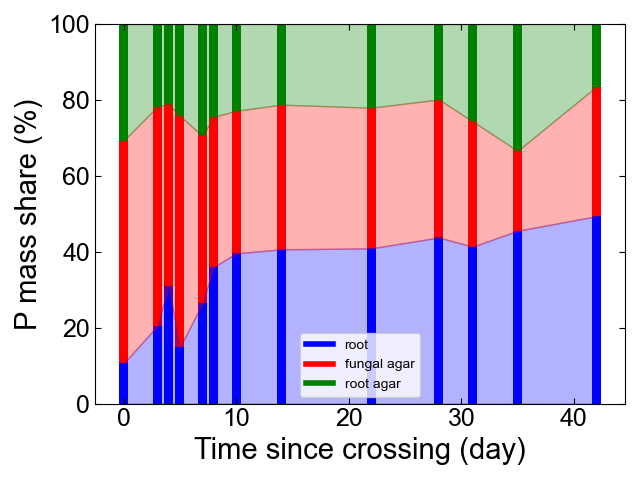

In [8]:
from matplotlib.lines import Line2D
select= grouped[grouped['fullP']>0]
select= select[select['treatment']=='100P']
select = select[select['plate']!=431]
select = select[select['plate']!=487]

t2_values = select['t2 (day)'].unique()
color_dict = {
    'root': 'blue',
    'agar': 'red',
    'rootagar': 'green'
}
# Plotting
fig, ax = plt.subplots()
blues = []
reds = []
greens = []
t2s = []
for t2 in sorted(t2_values):
    plate_data = select[select['t2 (day)'] == t2]
    
    bottom = 0
    k=0
    for type_ in ['root', 'agar', 'rootagar']:
        value = plate_data[plate_data['type'] == type_]['fullP_rescaled'].mean()
            # print(t2,plate_data[plate_data['type'] == type_]['plate'])
        ax.bar(t2, value, bottom=bottom, color=color_dict[type_])
        bottom += value
   
        if k==0:
            blues.append(bottom)
        elif k==1:
            reds.append(bottom)
        else:
            greens.append(bottom)
        k+=1
    t2s.append(t2)
ax.fill_between(t2s,blues,color="blue",alpha = 0.3)
ax.fill_between(t2s,blues,reds,color="red",alpha = 0.3)
ax.fill_between(t2s,greens,reds,color="green",alpha = 0.3)

# Setting labels and title
ax.set_ylabel('fullP Value')
ax.set_xlabel('t2 Value')
ax.set_ylim(0,100)
color_dict = {
    'root': 'blue',
    'fungal agar': 'red',
    'root agar': 'green'
}
legend_elements = [Line2D([0], [0], color=color_dict[type_], lw=4, label=type_) for type_ in color_dict.keys()]
ax.legend(handles=legend_elements)
ax.set_ylabel('P mass share (%)')
ax.set_xlabel('Time since crossing (day)')
plt.tight_layout()

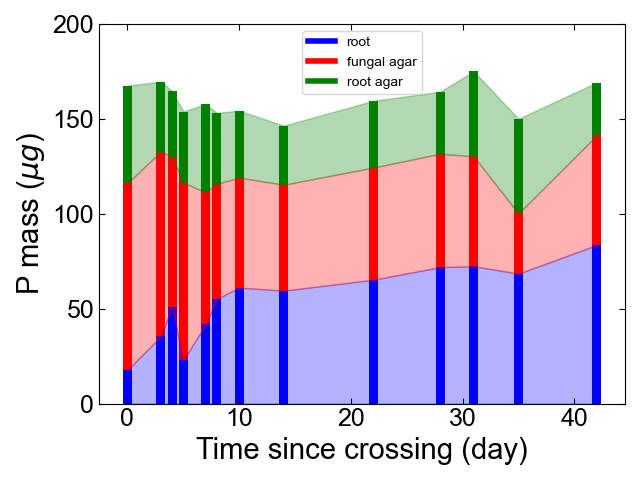

In [7]:
from matplotlib.lines import Line2D
select= grouped[grouped['fullP']>0]
select= select[select['treatment']=='100P']
select = select[select['plate']!=431]
select = select[select['plate']!=487]

t2_values = select['t2 (day)'].unique()
color_dict = {
    'root': 'blue',
    'agar': 'red',
    'rootagar': 'green'
}
# Plotting
fig, ax = plt.subplots()
blues = []
reds = []
greens = []
t2s = []
for t2 in sorted(t2_values):
    plate_data = select[select['t2 (day)'] == t2]
    
    bottom = 0
    k=0
    for type_ in ['root', 'agar', 'rootagar']:
        value = plate_data[plate_data['type'] == type_]['fullP'].mean()
            # print(t2,plate_data[plate_data['type'] == type_]['plate'])
        ax.bar(t2, value, bottom=bottom, color=color_dict[type_])
        bottom += value
   
        if k==0:
            blues.append(bottom)
        elif k==1:
            reds.append(bottom)
        else:
            greens.append(bottom)
        k+=1
    t2s.append(t2)
ax.fill_between(t2s,blues,color="blue",alpha = 0.3)
ax.fill_between(t2s,blues,reds,color="red",alpha = 0.3)
ax.fill_between(t2s,greens,reds,color="green",alpha = 0.3)

# Setting labels and title
ax.set_ylabel('fullP Value')
ax.set_xlabel('t2 Value')
ax.set_ylim(0,200)
color_dict = {
    'root': 'blue',
    'fungal agar': 'red',
    'root agar': 'green'
}
legend_elements = [Line2D([0], [0], color=color_dict[type_], lw=4, label=type_) for type_ in color_dict.keys()]
ax.legend(handles=legend_elements)
ax.set_ylabel('P mass ($\mu g$)')
ax.set_xlabel('Time since crossing (day)')
plt.tight_layout()

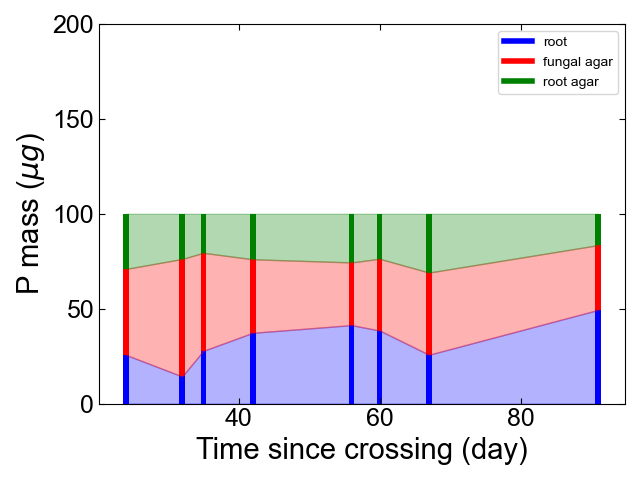

In [8]:
from matplotlib.lines import Line2D
select= grouped[grouped['fullP']>0]
select= select[select['treatment']=='100P']
select = select[select['plate']!=431]
select = select[select['plate']!=487]

t2_values = select['time_elapsed_day'].unique()
color_dict = {
    'root': 'blue',
    'agar': 'red',
    'rootagar': 'green'
}
# Plotting
fig, ax = plt.subplots()
blues = []
reds = []
greens = []
t2s = []
for t2 in sorted(t2_values):
    plate_data = select[select['time_elapsed_day'] == t2]
    
    bottom = 0
    k=0
    for type_ in ['root', 'agar', 'rootagar']:
        value = plate_data[plate_data['type'] == type_]['fullP_rescaled'].mean()
            # print(t2,plate_data[plate_data['type'] == type_]['plate'])
        ax.bar(t2, value, bottom=bottom, color=color_dict[type_])
        bottom += value
   
        if k==0:
            blues.append(bottom)
        elif k==1:
            reds.append(bottom)
        else:
            greens.append(bottom)
        k+=1
    t2s.append(t2)
ax.fill_between(t2s,blues,color="blue",alpha = 0.3)
ax.fill_between(t2s,blues,reds,color="red",alpha = 0.3)
ax.fill_between(t2s,greens,reds,color="green",alpha = 0.3)

# Setting labels and title
ax.set_ylabel('fullP Value')
ax.set_xlabel('t2 Value')
ax.set_ylim(0,200)
color_dict = {
    'root': 'blue',
    'fungal agar': 'red',
    'root agar': 'green'
}
legend_elements = [Line2D([0], [0], color=color_dict[type_], lw=4, label=type_) for type_ in color_dict.keys()]
ax.legend(handles=legend_elements)
ax.set_ylabel('P mass ($\mu g$)')
ax.set_xlabel('Time since crossing (day)')
plt.tight_layout()

In [9]:
select= grouped[grouped['fullP']>0]
select= select[select['treatment']=='100P']
select['plate'].unique()

array([416., 420., 427., 431., 436., 439., 440., 443., 447., 460., 481.,
       482., 483., 485., 486., 487., 490., 491., 492., 494., 495.])

<AxesSubplot: >

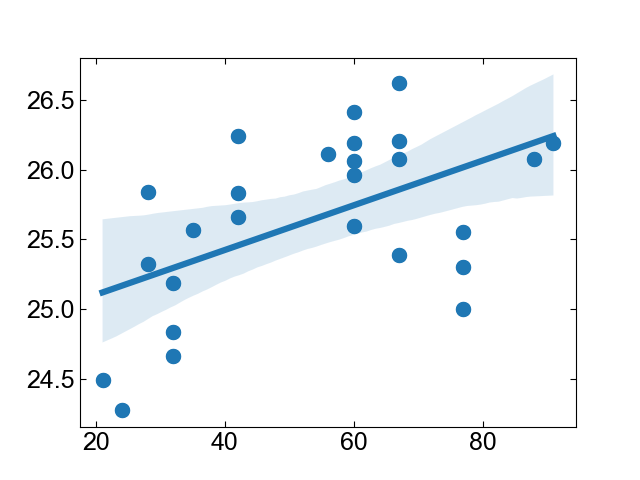

In [10]:
from scipy.stats import mode
fig, ax = plt.subplots()

select= grouped[grouped['type'] != 'rootagartot']
select= select[select['type'] != 'agartot']
# select= select[select['treatment']=='100P']


select = select[select['plate']!=431]
select = select[select['plate']!=487]
select = select[select['type']=="agar"]
xlabel = 'time_elapsed_day'
y = select.groupby('plate')['measured_tot_wet_weight'].sum().values
x = select.groupby('plate')[xlabel].mean().values
ax.scatter(x,y)
sns.regplot(x=x,y=y)


In [11]:
select= grouped[grouped['fullP']>0]
select= select[select['treatment']=='0P']
select= select[select['type'] != 'rootagartot']
select= select[select['type'] != 'agartot']
select.groupby('plate')['fullP'].sum()

plate
463.0    136.171456
464.0    138.129362
468.0    108.579856
470.0    146.112435
471.0    129.897726
474.0    133.558511
478.0    123.868892
Name: fullP, dtype: float64

In [12]:
grouped_0P = df.groupby(['plate', 'type']).agg({'totP (ug)': 'sum', 'wet weight': 'sum'}).reset_index()
grouped_0P = grouped_0P[grouped_0P['type']=="agar0P"]


datf = grouped_0P

# Function to compute concentration
def compute_concentration(df):
    total_totP = df['totP (ug)'].sum()
    total_wet_weight = df['wet weight'].sum()
    return total_totP / total_wet_weight

# Original concentration
original_concentration = compute_concentration(df)
print(f'Original Concentration: {original_concentration}')

# Bootstrap
n_iterations = 1000  # Number of bootstrap samples to create
bootstrap_estimates = []  # Initialize an empty list to keep the bootstrap concentration estimates

for i in range(n_iterations):
    # Generate a random bootstrap sample (same size as original sample, with replacement)
    bootstrap_sample = datf.sample(n=len(df), replace=True)
    
    # Compute the concentration from the bootstrap sample
    bootstrap_concentration = compute_concentration(bootstrap_sample)
    
    # Append the concentration to the list of bootstrap estimates
    bootstrap_estimates.append(bootstrap_concentration)

# Estimate the confidence intervals
confidence_level = 0.95
lower_percentile = (1.0 - confidence_level)/2.0 * 100
upper_percentile = (1.0 + confidence_level)/2.0 * 100
ci_lower = np.percentile(bootstrap_estimates, lower_percentile)
ci_upper = np.percentile(bootstrap_estimates, upper_percentile)

print(f'{confidence_level*100}% Confidence Interval for concentration: ({ci_lower}, {ci_upper})')


Original Concentration: 3.4284406148657527
95.0% Confidence Interval for concentration: (2.785069663432237, 2.8004215357507953)


Text(0, 0.5, 'C_P of type root agar')

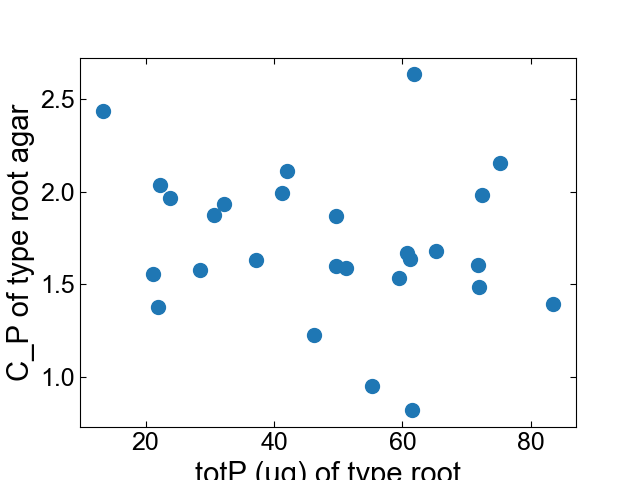

In [13]:
fig,ax = plt.subplots()

# Assume 'grouped' is your original DataFrame

# Filter DataFrames for 'root' and 'root agar'
df_root = grouped[grouped['type'] == 'root']
df_root_agar = grouped[grouped['type'] == 'rootagar']

# Drop rows where 'plate' is 431 for 'root'
df_root = df_root[df_root['plate'] != 431]

# Create DataFrames with only 'plate' and the column of interest
df_root = df_root[['plate', 'totP (ug)']]
df_root_agar = df_root_agar[['plate', 'C_P']]

# Merge the two DataFrames on 'plate'
merged_df = pd.merge(df_root, df_root_agar, on='plate')

# Plotting
ax.scatter(merged_df['totP (ug)'], merged_df['C_P'])
ax.set_xlabel('totP (ug) of type root')
ax.set_ylabel('C_P of type root agar')
# ax.title('Scatter Plot of C_P vs totP by Plate')
# plt.show()


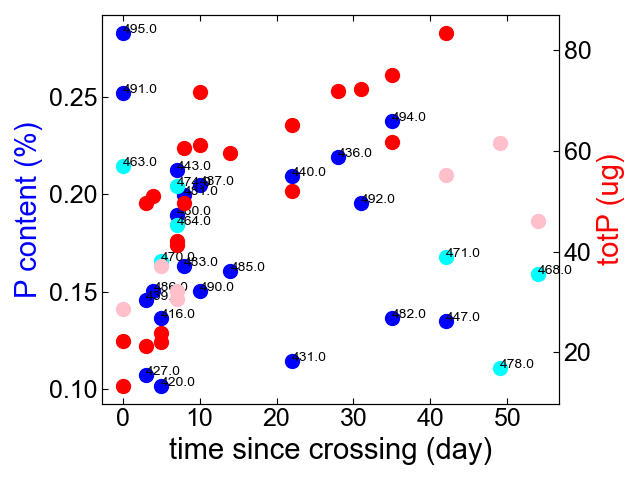

In [14]:
# Assuming 'grouped' is your original DataFrame and 'roots' is a filtered DataFrame
roots = grouped[grouped['type']=='root']
# roots = roots[roots['plate']!=431]

# Create two masks for '100P' and '0P'
mask_100P = roots['treatment'] == '100P'
mask_0P = roots['treatment'] == '0P'

fig, ax = plt.subplots()

# Plot for '100P' treatment with original blue and red colors
ax.scatter(roots[mask_100P]['t2 (day)'], roots[mask_100P]['totP (ug)']/roots[mask_100P]['dry weight']/1e4, color='blue')
for index,row in roots.iterrows():
    ax.text(row['t2 (day)'],row['totP (ug)']/row['dry weight']/10000,row['plate'])
ax2 = ax.twinx()
ax2.scatter(roots[mask_100P]['t2 (day)'], roots[mask_100P]['totP (ug)'], color='red')

# Plot for '0P' treatment with new cyan and pink colors
ax.scatter(roots[mask_0P]['t2 (day)'], roots[mask_0P]['totP (ug)']/roots[mask_0P]['dry weight']/1e4, color='cyan')
ax2.scatter(roots[mask_0P]['t2 (day)'], roots[mask_0P]['totP (ug)'], color='pink')

# Labels and formatting
ax.set_xlabel("time since crossing (day)")
ax.set_ylabel("P content (%)", color="blue")
ax2.set_ylabel("totP (ug)", color="red")
plt.tight_layout()

plt.show()


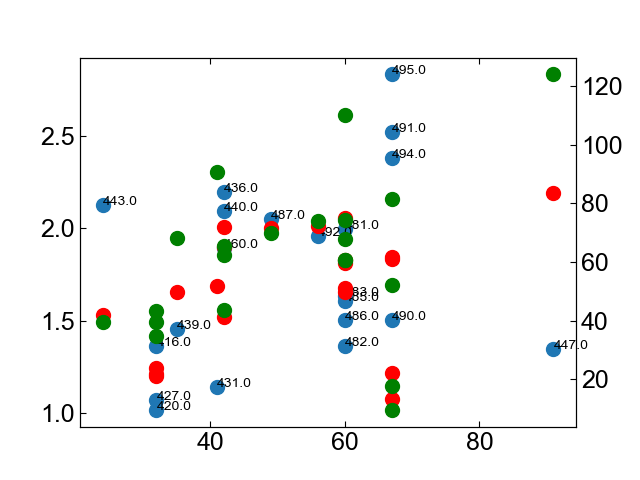

In [15]:
roots = grouped[grouped['type']=='root']
# roots = roots[roots['plate']!=431]
roots = roots[roots['treatment']=='100P']

fig,ax = plt.subplots()
ax.scatter(roots['time_elapsed_day'],roots['totP (ug)']/roots['dry weight']/1000)
for index,row in roots.iterrows():
    ax.text(row['time_elapsed_day'],row['totP (ug)']/row['dry weight']/1000,row['plate'])
ax2 = ax.twinx()
ax2.scatter(roots['time_elapsed_day'],roots['totP (ug)'],color = "red")
ax2.scatter(roots['time_elapsed_day'],roots['dry weight']*2000,color = "green")


In [ ]:
grouped.loc

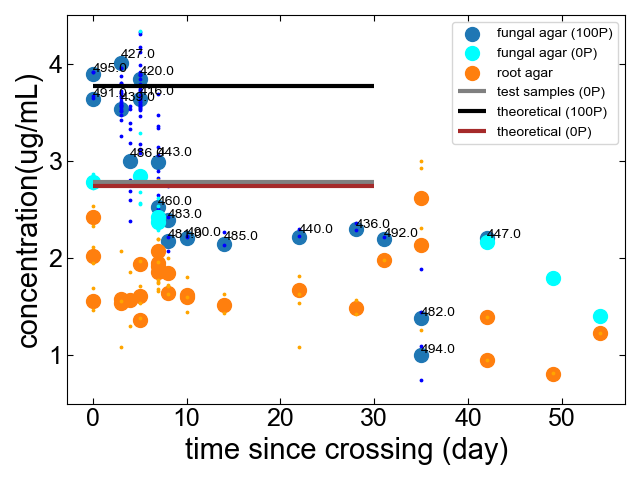

In [17]:
roots = grouped[grouped['type']=='agar']
roots = roots[roots['treatment']=='100P']
roots = roots[roots['plate']!=431]
roots = roots[roots['plate']!=487]

df_select = df[df['type']=='agar']
df_select = df_select[df_select['treatment']=='100P']
df_select = df_select[df_select['plate']!=431]
df_select = df_select[df_select['plate']!=487]

fig,ax = plt.subplots()
ax.scatter(roots['t2 (day)'],roots['totP (ug)']/roots['wet_weight_measured'], label = "fungal agar (100P)")
ax.scatter(df_select['t2 (day)'],df_select['totP (ug)']/df_select['wet weight'],color="blue",s=3)
for index,row in roots.iterrows():
    ax.text(row['t2 (day)'],row['C_P'],row['plate'])
roots = grouped[grouped['type']=='agar']
roots = roots[roots['treatment']=='0P']
df_select = df[df['type']=='agar']
df_select = df_select[df_select['treatment']=='0P']
# df_select = df_select[df_select['plate']!=431]
ax.scatter(roots['t2 (day)'],roots['totP (ug)']/roots['wet_weight_measured'],color="cyan", label = "fungal agar (0P)")
ax.scatter(df_select['t2 (day)'],df_select['totP (ug)']/df_select['wet weight'],color="cyan",s=3)


roots = grouped[grouped['type']=='rootagar']
df_select = df[df['type']=='rootagar']

roots = roots[roots['plate']!=431]
ax.scatter(roots['t2 (day)'],roots['totP (ug)']/roots['wet_weight_measured'],label = "root agar")
ax.scatter(df_select['t2 (day)'],df_select['totP (ug)']/df_select['wet weight'],color="orange",s=3)


mean0P = np.median(df[df['type']=='agar0P']['C_P'])
std = np.std(df[df['type']=='agar0P']['C_P'])

ax.set_ylabel('concentration(ug/mL)')
ax.set_xlabel('time since crossing (day)')

ax.hlines(mean0P,0,30, color = "grey",label = "test samples (0P)")
ax.hlines(3.77,0,30, color = "black",label = "theoretical (100P)")
ax.hlines(2.74,0,30, color = "brown",label = "theoretical (0P)")
# lower_bound = ci_lower
# upper_bound = ci_upper
# ax.axhspan(lower_bound, upper_bound, color='grey', alpha=0.5)
ax.set_ylim(0.5,4.5)
              
ax.legend()
plt.tight_layout()

In [ ]:
roots = grouped[grouped['type']=='agar']
roots = roots[roots['treatment']=='100P']
roots = roots[roots['plate']!=431]
df_select = df[df['type']=='agar']
df_select = df_select[df_select['treatment']=='100P']
df_select = df_select[df_select['plate']!=431]
roots[roots['plate']==494]['C_P'],df_select[df_select['plate']==494][['Sample_name','C_P']]


In [ ]:
fig,ax = plt.subplots()

roots = grouped[grouped['type']=='rootagar']
roots = roots[roots['treatment']=='100P']

roots = roots[roots['plate']!=431]
sns.scatterplot(roots,x= 'time_elapsed_day',y = 'fullP')
for index,row in roots.iterrows():
    ax.text(row['time_elapsed_day'],row['fullP'],row['plate'])

In [ ]:
fig,ax = plt.subplots()
roots = grouped.loc[grouped['type']=='rootagar']

roots = roots[roots['plate']!=431]
x = 'time_elapsed_day'
ax.scatter(roots[x],roots['C_P'])
for index,row in roots.iterrows():
    ax.text(row[x],row['C_P'],row['plate'])
ax.set_xlabel('time since innoculation (day)')
ax.set_ylabel('root agar P concentration (ug/mL)')
sns.regplot(roots,x=x,y='C_P',scatter=False,color="black")


In [ ]:
grouped

In [ ]:


# Group the data by 'plate' and 'type', then sum up 'totP (ug)'
# Group the data by 'plate' and 'type', then sum up 'totP (ug)'
select = df[df['treatment']=='100P']
select = select[select['plate']!=431]
select = select[select['plate']>0]



grouped = select.groupby(['t2 (day)', 'type']).agg({'totP (ug)' :'sum'}).reset_index()

# Create a dictionary to map 'type' to a specific color
color_dict = {'root': 'red', 'agar': 'blue', 'rootagar': 'purple'}

# Create the bar plot
fig, ax = plt.subplots()

# Get unique plates to set as categorical x-ticks
unique_times = grouped['t2 (day)'].unique()

# Initialize empty lists to hold bar heights for each plate
bar_data = {time: [] for time in unique_times}
bar_colors = {time: [] for time in unique_times}

# Prepare the data
for time in unique_times:
    # Filter data for each plate
    plate_data = grouped[grouped['t2 (day)'] == time]
    select_time = select[select['t2 (day)'] == time]

    # Initialize the bottom for the stacked bar
    bottom = 0
    num_plates = len(select_time["plate"].unique())
    print(num_plates)
    for index, row in plate_data.iterrows():
        # Add bar heights and colors
        bar_data[time].append(row['totP (ug)']/num_plates)
        bar_colors[time].append(color_dict[row['type']])

    # Plot the bars
for i, time in enumerate(unique_times):
    ax.bar(time, bar_data[time], bottom=[sum(bar_data[time][:j]) for j in range(len(bar_data[time]))], color=bar_colors[time])

# Add legend and labels
custom_legend = [plt.Rectangle((0,0),1,1, color=color_dict[key]) for key in color_dict.keys()]
ax.legend(custom_legend, ['root','fungal agar','root agar'], title='Types')

# Set x-ticks and labels
# ax.set_xticks(range(len(unique_plates)))
# ax.set_xticklabels([str(p) for p in unique_plates])

ax.set_xlabel('time since crossing (day)')
ax.set_ylabel('Total P (ug)')
# ax.set_ylim(0,120)
plt.tight_layout()


In [ ]:
import matplotlib.pyplot as plt

# Assuming df is already defined
select = df[df['treatment']=='100P']
select = select[select['plate']!=431]
select = select[select['plate']>0]
select = select[select['totP (ug)']>0]

grouped = select.groupby(['t2 (day)', 'type']).agg({'totP (ug)': 'sum'}).reset_index()

# Initialize dictionaries to hold y-values for each 'type'
root_values = {}
agar_values = {}
rootagar_values = {}

# Initialize a list for unique times
unique_times = []

# Populate the dictionaries and list
for index, row in grouped.iterrows():
    time = row['t2 (day)']
    select_time = select[select['t2 (day)'] == time]
    num_plates = len(select_time["plate"].unique())
    
    if time not in unique_times:
        unique_times.append(time)
    
    if row['type'] == 'root':
        root_values[time] = row['totP (ug)']/num_plates
    elif row['type'] == 'agar':
        agar_values[time] = row['totP (ug)']/num_plates
    elif row['type'] == 'rootagar':
        rootagar_values[time] = row['totP (ug)']/num_plates

# Sort unique_times and fill in missing values with zeros
unique_times.sort()
root_values_list = [root_values.get(t, 0) for t in unique_times]
agar_values_list = [agar_values.get(t, 0) for t in unique_times]
rootagar_values_list = [rootagar_values.get(t, 0) for t in unique_times]

# Create the stackplot
# fig, ax = plt.subplots()

ax.stackplot(unique_times,agar_values_list, root_values_list, rootagar_values_list, labels=['Fungal agar', 'Root', 'Root agar'], colors=['blue', 'red', 'purple'],alpha = 0.4)

ax.legend()
ax.set_xlabel('Time Since Crossing (Day)')
ax.set_ylabel('Total P (ug)')


In [ ]:


# Group the data by 'plate' and 'type', then sum up 'totP (ug)'
# Group the data by 'plate' and 'type', then sum up 'totP (ug)'
select = df[df['treatment']=='0P']
select = select[select['plate']!=431]
select = select[select['plate']>0]



grouped = select.groupby(['time_since_crossing_day', 'type']).agg({'totP (ug)' :'sum'}).reset_index()

# Create a dictionary to map 'type' to a specific color
color_dict = {'root': 'red', 'agar': 'blue', 'rootagar': 'purple'}

# Create the bar plot
fig, ax = plt.subplots()

# Get unique plates to set as categorical x-ticks
unique_times = grouped['time_since_crossing_day'].unique()

# Initialize empty lists to hold bar heights for each plate
bar_data = {time: [] for time in unique_times}
bar_colors = {time: [] for time in unique_times}

# Prepare the data
for time in unique_times:
    # Filter data for each plate
    plate_data = grouped[grouped['time_since_crossing_day'] == time]
    select_time = select[select['time_since_crossing_day'] == time]

    # Initialize the bottom for the stacked bar
    bottom = 0
    num_plates = len(select_time["plate"].unique())
    print(num_plates)
    for index, row in plate_data.iterrows():
        # Add bar heights and colors
        bar_data[time].append(row['totP (ug)']/num_plates)
        bar_colors[time].append(color_dict[row['type']])

    # Plot the bars
for i, time in enumerate(unique_times):
    ax.bar(i, bar_data[time], bottom=[sum(bar_data[time][:j]) for j in range(len(bar_data[time]))], color=bar_colors[time])

# Add legend and labels
custom_legend = [plt.Rectangle((0,0),1,1, color=color_dict[key]) for key in color_dict.keys()]
ax.legend(custom_legend, color_dict.keys(), title='Types')

# Set x-ticks and labels
ax.set_xticks(range(len(unique_plates)))
ax.set_xticklabels([str(p) for p in unique_plates])

ax.set_xlabel('Plate')
ax.set_ylabel('Total P (ug)')
plt.title('Sum of Total P (ug) by Plate and Type')

plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assume df is your dataframe
# Group the data by 'time_since_crossing_day', 'plate', and 'type', then sum up 'totP (ug)'
select = df[df['treatment']=='100P']
grouped = select.groupby(['time_since_crossing_day', 'plate', 'type'])['totP (ug)'].sum().reset_index()

# Create a dictionary to map 'type' to a specific color
color_dict = {'root': 'red', 'agar': 'blue', 'rootagar': 'purple'}

# Create the bar plot
fig, ax = plt.subplots()

# Get unique combinations of time_since_crossing_day and plate to set as categorical x-ticks
unique_combinations = grouped[['time_since_crossing_day', 'plate']].drop_duplicates().sort_values('time_since_crossing_day')

# Initialize empty lists to hold bar heights and colors
bar_data = {}
bar_colors = {}

# Prepare the data
for _, row in unique_combinations.iterrows():
    time, plate = row['time_since_crossing_day'], row['plate']
    combo_key = f"{time}_{plate}"
    # Filter data for each time_since_crossing_day and plate
    combo_data = grouped[(grouped['time_since_crossing_day'] == time) & (grouped['plate'] == plate)]
    
    bar_data[combo_key] = []
    bar_colors[combo_key] = []

    for index, row in combo_data.iterrows():
        # Add bar heights and colors
        bar_data[combo_key].append(row['totP (ug)'])
        bar_colors[combo_key].append(color_dict[row['type']])

# Plot the bars
for i, combo_key in enumerate(bar_data.keys()):
    ax.bar(i, bar_data[combo_key], bottom=[sum(bar_data[combo_key][:j]) for j in range(len(bar_data[combo_key]))], color=bar_colors[combo_key])

# Add legend and labels
custom_legend = [plt.Rectangle((0,0),1,1, color=color_dict[key]) for key in color_dict.keys()]
ax.legend(custom_legend, color_dict.keys(), title='Types')

# Set x-ticks and labels
ax.set_xticks(range(len(bar_data)))
ax.set_xticklabels([str(combo_key) for combo_key in bar_data.keys()], rotation=90)

ax.set_xlabel('Time Since Crossing Day_Plate')
ax.set_ylabel('Total P (ug)')
plt.title('Sum of Total P (ug) by Time Since Crossing Day and Plate')

plt.show()


In [ ]:
bar_data

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Group the data by 'plate' and 'type', then sum up 'totP (ug)'
# Group the data by 'plate' and 'type', then sum up 'totP (ug)'
# Group the data by 'plate' and 'type', then sum up 'totP (ug)' and 'wet weight'
df = pd.read_excel(path_excel)
df = df[df['type'] != 'root']
grouped = df.groupby(['plate', 'type']).agg({'totP (ug)': 'sum', 'wet weight': 'sum'}).reset_index()

# Calculate the ratio: sum('totP (ug)') / sum('wet weight')
grouped['P_to_weight_ratio'] = grouped['totP (ug)'] / grouped['wet weight']

# Create a dictionary to map 'type' to a specific color
color_dict = {'root': 'red', 'agar': 'blue', 'rootagar': 'purple'}

# Create the bar plot
fig, ax = plt.subplots()

# Get unique plates to set as categorical x-ticks
unique_plates = grouped['plate'].unique()

# Initialize empty lists to hold bar heights for each plate
bar_data = {plate: [] for plate in unique_plates}
bar_colors = {plate: [] for plate in unique_plates}
bar_width = 0.35  # width of the bars
# Prepare the data
# Prepare and plot the data
for i, plate in enumerate(unique_plates):
    if plate>=0:
        plate_data = grouped[grouped['plate'] == plate]

        for j, row in plate_data.iterrows():
            color = color_dict[row['type']]
            position = i + (bar_width / 2) if row['type'] == 'agar' else i - (bar_width / 2)
            ax.bar(position, row['P_to_weight_ratio'], width=bar_width, color=color, label=row['type'])


# Add legend and labels
custom_legend = [plt.Rectangle((0,0),1,1, color=color_dict[key]) for key in color_dict.keys()]
ax.legend(custom_legend, color_dict.keys(), title='Types')

# Set x-ticks and labels
ax.set_xticks(range(len(unique_plates)))
ax.set_xticklabels([str(p) for p in unique_plates])

ax.set_xlabel('Plate')
ax.set_ylabel('Concentration P (ug/mL)')
plt.title('Sum of Total P (ug) by Plate and Type')

plt.show()


In [ ]:
baseline = grouped[grouped['plate'].between(1,4)]['P_to_weight_ratio'].mean()
baseline_std = grouped[grouped['plate'].between(1,4)]['P_to_weight_ratio'].std()
baseline,baseline_std

In [ ]:
df = pd.read_excel(path_excel)

# Calculate time elapsed as in your original code
df['day'] = pd.to_datetime(df['day'], format='%Y%m%d')  # Update the format as necessary
df['day_start'] = pd.to_datetime(df['start'], format='%Y%m%d')  # Update the format as necessary

df['time_elapsed'] = df['day'] - df['day_start']
df['time_elapsed_day'] = df['time_elapsed'].dt.days

# Filter out rows where 'type' is 'root'
df = df[df['type'].isin([ 'rootagar',"agar"])]
df = df[df['plate'] >= 10]
df = df[df['plate'] != 431]



# Group the data by 'time_elapsed_day' and 'type', then sum up 'totP (ug)' and 'wet weight'
# grouped = df.groupby(['time_elapsed_day', 'type','plate']).agg({'totP (ug)': 'sum', 'wet weight': 'sum'}).reset_index()
grouped = df.groupby(['time_elapsed_day', 'type']).agg({'totP (ug)': 'sum', 'wet weight': 'sum'}).reset_index()

# Calculate the ratio: sum('totP (ug)') / sum('wet weight')
grouped['P_to_weight_ratio'] = grouped['totP (ug)'] / grouped['wet weight']

# Create a dictionary to map 'type' to a specific color
color_dict = {'root': 'red', 'agar': 'blue', 'rootagar': 'purple'}

# Create the bar plot
fig, ax = plt.subplots()

# Get unique time_elapsed_day to set as categorical x-ticks
unique_days = grouped['time_elapsed_day'].unique()

# Initialize empty lists to hold bar heights for each time_elapsed_day
bar_width = 0.35  # width of the bars

# Prepare the data
for i, day in enumerate(unique_days):
    day_data = grouped[grouped['time_elapsed_day'] == day]
    # print(day, day_data['plate'].unique())

    for j, row in day_data.iterrows():
        color = color_dict[row['type']]
        position = i + (bar_width / 2) if row['type'] == 'agar' else i - (bar_width / 2)
        ax.bar(position, row['P_to_weight_ratio'], width=bar_width, color=color, label=row['type'])

# Add legend and labels
custom_legend = [plt.Rectangle((0,0),1,1, color=color_dict[key]) for key in color_dict.keys()]
ax.legend(custom_legend, color_dict.keys(), title='Types')

# Set x-ticks and labels
ax.set_xticks(range(len(unique_days)))
ax.set_xticklabels([str(d) for d in unique_days])

ax.set_xlabel('Time Elapsed (Days)')
ax.set_ylabel('Concentration P (ug/mL)')

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Group the data by 'plate' and 'type', then sum up 'totP (ug)'
# Group the data by 'plate' and 'type', then sum up 'totP (ug)'
# Group the data by 'plate' and 'type', then sum up 'totP (ug)' and 'wet weight'
df = pd.read_excel(path_excel)
df = df[df['type'] != 'root']
grouped = df.groupby(['plate', 'type']).agg({'totP (ug)': 'sum', 'wet weight': 'sum'}).reset_index()

# Calculate the ratio: sum('totP (ug)') / sum('wet weight')
grouped['P_to_weight_ratio'] = grouped['totP (ug)'] / grouped['wet weight']

# Create a dictionary to map 'type' to a specific color
color_dict = {'root': 'red', 'agar': 'blue', 'rootagar': 'purple'}

# Create the bar plot
fig, ax = plt.subplots()

# Get unique plates to set as categorical x-ticks
unique_plates = grouped['plate'].unique()

# Initialize empty lists to hold bar heights for each plate
bar_data = {plate: [] for plate in unique_plates}
bar_colors = {plate: [] for plate in unique_plates}
bar_width = 0.35  # width of the bars
# Prepare the data
# Prepare and plot the data
for i, plate in enumerate(unique_plates):
    if plate>=0:
        plate_data = grouped[grouped['plate'] == plate]

        for j, row in plate_data.iterrows():
            color = color_dict[row['type']]
            position = i + (bar_width / 2) if row['type'] == 'agar' else i - (bar_width / 2)
            volume = 27 if row['type'] == 'agar' else 23
            ax.bar(position, row['P_to_weight_ratio']*volume, width=bar_width, color=color, label=row['type'])


# Add legend and labels
custom_legend = [plt.Rectangle((0,0),1,1, color=color_dict[key]) for key in color_dict.keys()]
ax.legend(custom_legend, color_dict.keys(), title='Types')

# Set x-ticks and labels
ax.set_xticks(range(len(unique_plates)))
ax.set_xticklabels([str(p) for p in unique_plates])

ax.set_xlabel('Plate')
ax.set_ylabel('Concentration P (ug/mL)')
plt.title('Sum of Total P (ug) by Plate and Type')

plt.show()


In [ ]:
from PIL import Image
df = pd.read_excel(path_excel)
df = df[df['type'] != 'root']
df = df[df['type'] != 'rootagar']
df['pos'] = df['Sample_name'].str.split('-').str.get(1).astype(int)
df['C_P'] = df['totP (ug)']/df['wet weight'] 
basic_mapping = {
    1: (0, 0), 2: (0, 1), 3: (0, 2), 4: (0, 3), 5: (0, 4),
    6: (1, 0), 7: (1, 1), 8: (1, 2), 9: (1, 3), 10: (1, 4),
    11: (2, 0), 12: (2, 1), 13: (2, 2), 14: (2, 3), 15: (2, 4),
    16: (3, 1), 17: (3, 2), 18: (3, 3)
}

# Mapping for "coarse" to "basic"
coarse_to_basic_mapping = {
    1: [1, 2],
    2: [3, 8],
    3: [4, 5],
    4: [6, 7],
    5: [9, 10],
    6: [11, 12],
    7: [13],
    8: [14, 15],
    9: [16, 17, 18]
}

# Mapping for "simple" to "basic"
simple_to_basic_mapping = {
    0: list(range(1, 11)),
    1: list(range(11, 19))
}

# Initialize plot
plt.close("all")
for idx, unique_id in enumerate(df['unique_id'].unique()):
    if type(unique_id) ==str:
        fig,ax = plt.subplots()
        plate_df = df[df['unique_id'] == unique_id]

        # Create an empty 4x5 grid (for "basic" arrangement, adjust as needed)
        grid = np.zeros((4, 5))

        for i, row in plate_df.iterrows():
            arrangement = row['arrangement']
            pos = row['pos']
            totP = row['C_P']

            if arrangement == 'basic':
                x, y = basic_mapping[pos]
                grid[x, y] = totP

            elif arrangement == 'simple':
                for basic_pos in simple_to_basic_mapping[pos]:
                    x, y = basic_mapping[basic_pos]
                    grid[x, y] = totP

            elif arrangement == 'coarse':
                for basic_pos in coarse_to_basic_mapping[pos]:
                    x, y = basic_mapping[basic_pos]
                    grid[x, y] = totP

        # Plotting the grid
        image_path = os.path.join("C:\\Users\\coren\\AMOLF-SHIMIZU Dropbox\\DATA\\PRINCE_ANALYSIS", unique_id)

        # Find the image in the folder with name like 'StitchedImage_YYYYMMDD_hhmm.tif'
        for image_file in os.listdir(image_path):
            if 'StitchedImage' in image_file:
                img = Image.open(os.path.join(image_path, image_file))

        # Display the image
        ax.imshow(np.flip(np.array(img),axis = 1), cmap='gray', extent=[-0.5, 4.5, -0.5, 3.5])
        c = ax.imshow(grid, cmap='Reds', aspect='auto',vmin=mean0P,vmax=4,alpha = 0.5)
        cbar = fig.colorbar(c, ax=ax)
        cbar.set_label('P contration (ug/mL)', rotation=270, labelpad=20)
        # ax.set_title(f'Plate {unique_id}')
        ax.set_xticks([])
        ax.set_yticks([])
        
    # break
# plt.show()

In [ ]:
for polygon in polygons:
    

In [ ]:
df = df[df['C_P'] >=10]
df

In [ ]:
df = pd.read_excel(path_excel)
df = df[df['type'] != 'root']
df = df[df['type'] != 'rootagar']
df = df[df['type'] != 'reference sample']
df = df[df['type'] != 'empty']
df = df[df['comment'] != 'outlier']
df = df[df['plate'] != 431]



df['pos'] = df['Sample_name'].str.split('-').str.get(1).astype(int)
df['C_P'] = df['totP (ug)']/df['wet weight'] 
fig,ax = plt.subplots()
ax.hist(df['C_P'])

In [ ]:
df['time_elapsed']

In [ ]:
df['date_from_unique_id']

In [ ]:
import seaborn as sns
fig,ax = plt.subplots()

df = pd.read_excel(path_excel)
df = df[df['type'] != 'root']
df = df[df['type'] != 'rootagar']
df = df[df['type'] != 'reference sample']
df = df[df['type'] != 'empty']
df = df[df['comment'] != 'outlier']
df = df[df['plate'] != 431]
df = df[df['plate'] != 0]
df = df[df['plate'] != 1]



df['C_P'] = df['totP (ug)']/df['wet weight'] 

df['date_from_unique_id'] = pd.to_datetime(df['unique_id'].str.split('_').str[1], format='%Y%m%d')
    
# Convert 'day' column to datetime
df['day'] = pd.to_datetime(df['day'], format='%Y%m%d')  # Update the format as necessary

# Calculate time elapsed and store it in a new column
df['time_elapsed'] = df['day'] - df['date_from_unique_id']
df['time_elapsed_day'] = df['time_elapsed'].dt.days
# Filter DataFrame by treatment type
df_0P = df[df['treatment'] == '0P']
df_100P = df[df['treatment'] == '100P']

# Create scatter plot
sns.scatterplot(x='time_elapsed_day', y='C_P', data=df, hue='treatment', palette="Set2",alpha = 0.6)


plt.title('Time Elapsed vs C_P')
plt.xlabel('Time Elapsed (days)')
plt.ylabel('C_P')
# plt.axhline(y=baseline, color='r', linestyle='--', label='Mean')
mean0P = np.median(df[df['type']=='agar0P']['C_P'])
std = np.std(df[df['type']=='agar0P']['C_P'])
lower_bound = mean0P-std
upper_bound = mean0P+std
ax.axhspan(lower_bound, upper_bound, color='red', alpha=0.5, label='Confidence Interval')

ax.hlines(mean0P,0,28)
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
fig,ax = plt.subplots()
df = pd.read_excel(path_excel)
df = df[df['type'] != 'root']
df = df[df['type'] != 'rootagar']
df = df[df['type'] != 'reference sample']
df = df[df['type'] != 'empty']
df = df[df['comment'] != 'outlier']
df = df[df['plate'] != 431]
df = df[df['plate'] != 0]
df = df[df['plate'] != 1]
# df = df[df['treatment'] != '0P']


df['C_P'] = df['totP (ug)']/df['wet weight'] 

df['date_from_unique_id'] = pd.to_datetime(df['unique_id'].str.split('_').str[1], format='%Y%m%d')
    
# Convert 'day' column to datetime
df['day'] = pd.to_datetime(df['day'], format='%Y%m%d')  # Update the format as necessary

# Calculate time elapsed and store it in a new column
df['time_elapsed'] = df['day'] - df['date_from_unique_id']
df['time_elapsed_day'] = df['time_elapsed'].dt.days

# Group the data by 'plate' and 'time_elapsed_day', then sum up 'totP (ug)' and 'wet weight'
grouped = df.groupby(['plate', 'time_elapsed_day','treatment']).agg({'totP (ug)': 'sum', 'wet weight': 'sum'}).reset_index()

# Calculate the ratio: sum('totP (ug)') / sum('wet weight')
grouped['P_to_weight_ratio'] = grouped['totP (ug)'] / grouped['wet weight']
grouped['plate'] = grouped['plate'].astype(str)


# Scatter plot for aggregated concentration by plate as function of time elapsed
sns.scatterplot(x='time_elapsed_day', y='P_to_weight_ratio', data=grouped, hue='treatment', palette='viridis')

# Boxplot for each day
# sns.boxplot(x='time_elapsed_day', y='P_to_weight_ratio', data=grouped, color='grey', boxprops=dict(alpha=0.4))

plt.title('Aggregated Concentration P by Plate as Function of Time')
plt.xlabel('Time Elapsed (days)')
plt.ylabel('Aggregated Concentration P (ug/mL)')
ax.axhspan(lower_bound, upper_bound, color='red', alpha=0.5, label='Confidence Interval')
plt.axhline(y=baseline, color='r', linestyle='--', label='Mean')
plt.show()


In [ ]:
grouped